In [9]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import cv2

# 1. Load Model

In [10]:
# create an interpreter object that can run TensorFlow Lite model.
interpreter = tf.lite.Interpreter(model_path='lite-model_movenet_singlepose_thunder_3.tflite')

#ِِِ Allocate memory for the model's input and output tensors.
interpreter.allocate_tensors()

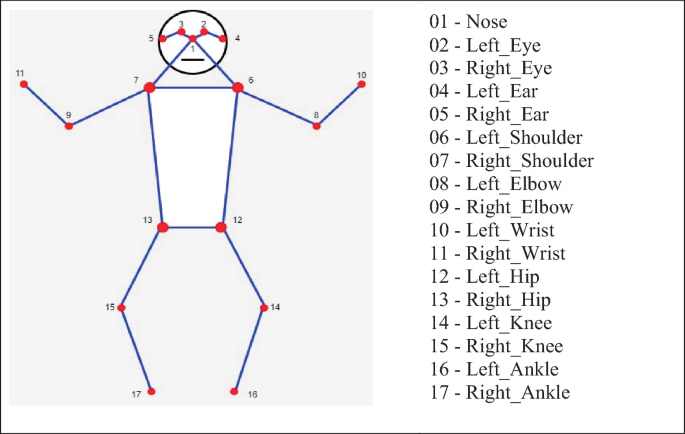

#  Draw Keypoints

In [11]:
def draw_keypoints(frame, keypoints, confidence_threshold):
    # Mapping keypoints to the original image (Scaling Key points)
    y, x, c = frame.shape
    scaled = np.squeeze(np.multiply(keypoints, [y,x,1]))
    
    for Key_p in scaled:
        Key_y, Key_x, conf = Key_p
        if conf > confidence_threshold:
            cv2.circle(frame, (int(Key_x), int(Key_y)), 4, (244, 247, 30), -1) 

#  Draw Edges

In [12]:
EDGES = {
    (0, 1): 'm',
    (0, 2): 'c',
    (1, 3): 'm',
    (2, 4): 'c',
    (0, 5): 'm',
    (0, 6): 'c',
    (5, 7): 'm',
    (7, 9): 'm',
    (6, 8): 'c',
    (8, 10): 'c',
    (5, 6): 'y',
    (5, 11): 'm',
    (6, 12): 'c',
    (11, 12): 'y',
    (11, 13): 'm',
    (13, 15): 'm',
    (12, 14): 'c',
    (14, 16): 'c'
}

# Draw Connections

In [13]:
def draw_connections(frame, keypoints, edges, confidence_threshold):
    y, x, c = frame.shape
    shaped = np.squeeze(np.multiply(keypoints, [y,x,1]))
    
    for edge, color in edges.items():
        p1, p2 = edge
        y1, x1, c1 = shaped[p1]
        y2, x2, c2 = shaped[p2]
        
        if (c1 > confidence_threshold) & (c2 > confidence_threshold):      
            cv2.line(frame, (int(x1), int(y1)), (int(x2), int(y2)), (185, 45, 204), 2)

In [14]:
interpreter.get_input_details()

[{'name': 'serving_default_input:0',
  'index': 0,
  'shape': array([  1, 256, 256,   3]),
  'shape_signature': array([  1, 256, 256,   3]),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

#  Make Detections

In [17]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()             # Shape (480, 640, 3)

    # Reshape to a float32 tensor of shape (256 x 256 x 3) 
    img = frame.copy()
    img = tf.image.resize_with_pad(np.expand_dims(img, axis=0), 256,256)
    input_image = tf.cast(img, dtype=tf.float32)                                    

    # Setup input and output 
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    # Make predictions 
    # set the value of the input tensor 
    interpreter.set_tensor(input_details[0]['index'], np.array(input_image))   
    # triggers the TensorFlow Lite model to process the input and generate the corresponding output.    
    interpreter.invoke()        
    # predicted keypoints along with their corresponding scores.
    keypoints_with_scores = interpreter.get_tensor(output_details[0]['index'])
    print(keypoints_with_scores)
    

    # Rendering 
    draw_connections(frame, keypoints_with_scores, EDGES, 0.4)
    draw_keypoints(frame, keypoints_with_scores, 0.4)
    
    
    cv2.imshow('MoveNet Thunder', cv2.flip(frame, 1))
    if cv2.waitKey(10) & 0xFF==ord('q'):
        break
        
cap.release()
cv2.destroyAllWindows()

[[[[0.58250254 0.5313335  0.6196822 ]
   [0.5207091  0.5785768  0.7342462 ]
   [0.5231999  0.47473884 0.8601153 ]
   [0.54274243 0.637152   0.7896122 ]
   [0.55146843 0.40333796 0.56322396]
   [0.7780241  0.74674106 0.8404169 ]
   [0.77599436 0.29048994 0.7329881 ]
   [0.9873392  1.0246671  0.00850472]
   [0.87184584 0.22139224 0.00855447]
   [0.5999998  0.5991997  0.05359501]
   [0.7173473  0.23347019 0.05059377]
   [0.917693   0.74039835 0.00283234]
   [0.89450157 0.25330257 0.00843504]
   [0.79482037 0.7546684  0.00869119]
   [0.7389799  0.26670417 0.02650042]
   [0.6568855  0.6100828  0.00867848]
   [0.72282577 0.24065262 0.02124656]]]]
[[[[0.5761442  0.5328263  0.5800869 ]
   [0.51754797 0.58053106 0.67341053]
   [0.516887   0.4777456  0.81439453]
   [0.5457618  0.6360257  0.6496918 ]
   [0.5509423  0.4099227  0.6700982 ]
   [0.7700065  0.7412085  0.70361733]
   [0.7784217  0.29290038 0.7484134 ]
   [0.9859542  1.0267289  0.00679772]
   [0.8708788  0.22147863 0.00725345]
   [0.579

In [16]:
keypoints_with_scores.shape

(1, 1, 17, 3)